# Overview

The Defense Contractors dataset contains 269 across 8 columns of data representing market cap, revenue and earning of defense contractors. Approximately 9% of the data is missing.

We aim to handle all missing values and detect outliers to ensure the data is clean and suitable for model training

In [54]:
# import libraries

import pandas as pd
import numpy as np
import kaggle as kg

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

sns.set_theme(style='white')
np.random.seed(0)

In [ ]:
# authentica kaggle credential and download the dataset
kg.api.authenticate()

kg.api.dataset_download_files('prasertk/defense-contractors-market-cap-revenue-earning', unzip=True)

In [56]:
# load the data
df = pd.read_csv('data/defense_contractor.csv')
df.head()

,Symbol,Year,Name,Country,Category,Market cap,Revenue,Earnings
0,AM.PA,2022,Dassault Aviation,France,Aircraft manufacturers|Defense contractors|Man...,$11.91 B,NaN,NaN
1,BA,2001,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$30.94 B,$58.19 B,NaN
2,BA,2002,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$26.37 B,$54.06 B,NaN
3,BA,2003,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$33.72 B,$50.48 B,NaN
4,BA,2004,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$43.08 B,$52.51 B,NaN


# Data Exploration

In [57]:
# check the data types and shape of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Symbol      269 non-null    object
 1   Year        269 non-null    int64 
 2   Name        269 non-null    object
 3   Country     269 non-null    object
 4   Category    269 non-null    object
 5   Market cap  254 non-null    object
 6   Revenue     189 non-null    object
 7   Earnings    171 non-null    object
dtypes: int64(1), object(7)
memory usage: 16.9+ KB


In [58]:
# check the null values
df.isnull().sum()

Symbol         0
Year           0
Name           0
Country        0
Category       0
Market cap    15
Revenue       80
Earnings      98
dtype: int64

In [59]:
# check what percentage of the data is missing
total_null = df.isnull().sum().sum()
total_cells = np.prod(df.shape)
percentage_null = (total_null / total_cells) * 100
percentage_null

np.float64(8.968401486988848)

In [60]:
# check if there's duplicated rows
df.duplicated().sum()

np.int64(0)

In [61]:
# create a copy of the dataframe for manipulation
df1 = df.copy()

# Data Types

In [62]:
# check the new dataframe
df1.head()

,Symbol,Year,Name,Country,Category,Market cap,Revenue,Earnings
0,AM.PA,2022,Dassault Aviation,France,Aircraft manufacturers|Defense contractors|Man...,$11.91 B,NaN,NaN
1,BA,2001,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$30.94 B,$58.19 B,NaN
2,BA,2002,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$26.37 B,$54.06 B,NaN
3,BA,2003,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$33.72 B,$50.48 B,NaN
4,BA,2004,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,$43.08 B,$52.51 B,NaN


In [63]:
# convert Market cap, Revenue, and Earnings to numeric
df1['Market cap'] = df1['Market cap'].str.replace('$', '').str.replace('B', '').astype(float)
df1['Revenue'] = df1['Revenue'].str.replace('$', '').str.replace('B', '').astype(float)
df1['Earnings'] = df1['Earnings'].str.replace('$', '').str.replace('B', '').astype(float)

In [64]:
# convert Country and Category to category
df1[['Country', 'Category']] = df1[['Country', 'Category']].astype('category')

# Data Viz

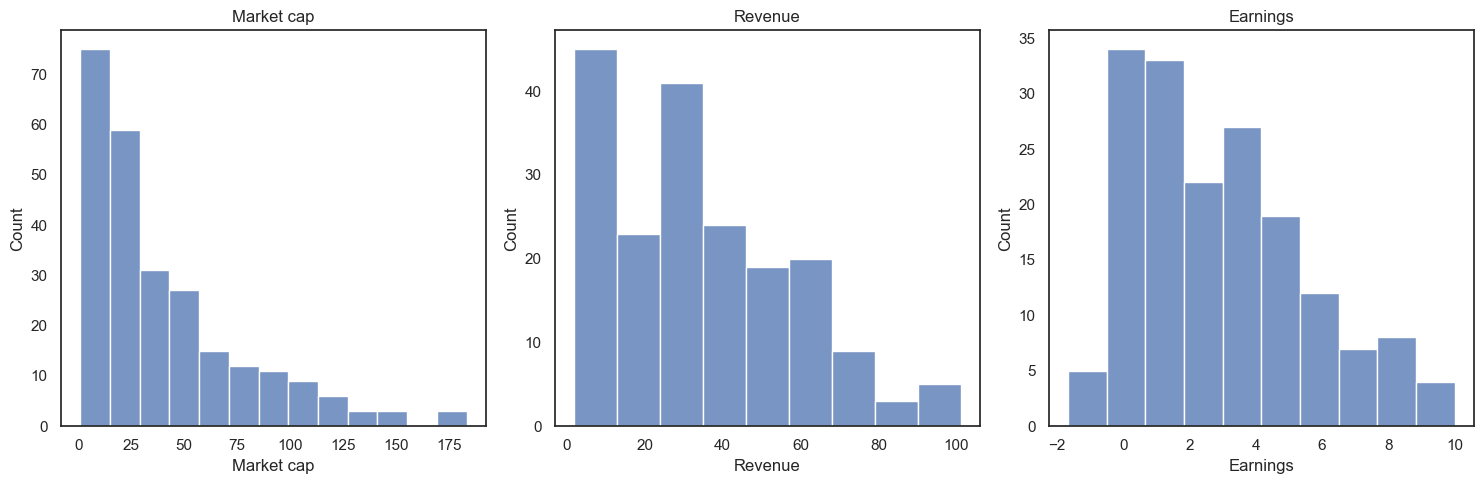

In [65]:
# select the numeric columns and turn them into a DataFrame which we'll use in later steps
num_cols = pd.DataFrame(df1, columns=['Market cap', 'Revenue', 'Earnings'])

# check the distribution of the numeric columns
plt.figure(figsize=(15, 5))
for i, column in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(x=df1[column])
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

All 3 columns are positively skewed to different degrees.

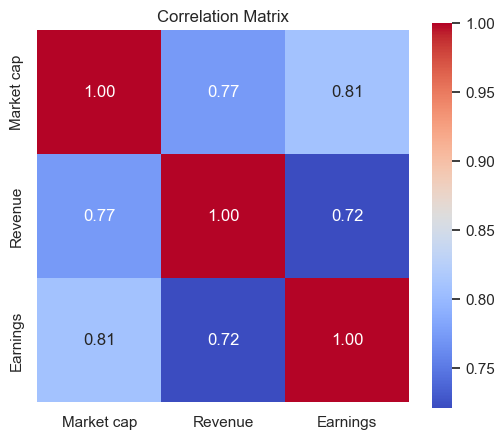

In [66]:
# check the correlation between the numeric columns

corr = num_cols.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap="coolwarm", square=True)
plt.title('Correlation Matrix')
plt.show()

There are strong correlations between the 3 columns.

# Missing Values

There are several ways we can use the correlation between our numeric columns to impute the missing values. For example, we could use the distribution of the non-nulls values of a given column to impute the missing values of the other(s), and vice versa. Given the skewness of the data, for example **Market cap**, this would likely require a logarithmic transformation before imputation.

In this project, we will use linear regression imputation.

In [67]:
# impute missing values in Earnings based on its linear relationship with Market cap
mc_e_data = df1.dropna(subset=['Market cap', 'Earnings'])

reg = LinearRegression()
reg.fit(mc_e_data[['Market cap']], mc_e_data['Earnings'])

# predict missing Earnings values
df1.loc[df1['Earnings'].isna(), 'Earnings'] = reg.predict(df1.loc[df1['Earnings'].isna(), ['Market cap']])

In [68]:
# impute missing values in Revenue, based on its linear relationship with Market cap
mc_r_data = df1.dropna(subset=['Market cap', 'Revenue'])

reg_r = LinearRegression()
reg_r.fit(mc_r_data[['Market cap']], mc_r_data['Revenue'])

# predict missing Revenue values
df1.loc[df1['Revenue'].isna(), 'Revenue'] = reg_r.predict(df1.loc[df1['Revenue'].isna(), ['Market cap']])

In [69]:
# impute missing values in Market cap, based on its linear relationship with Earnings and Revenue
mc_imp_data = df1.dropna(subset=['Revenue', 'Earnings', 'Market cap'])

reg_mc = LinearRegression()
reg_mc.fit(mc_imp_data[['Revenue', 'Earnings']], mc_imp_data['Market cap'])

# predict missing Market Cap values
df1.loc[df1['Market cap'].isna(), 'Market cap'] = np.maximum(
    reg_mc.predict(df1.loc[df1['Market cap'].isna(), ['Revenue', 'Earnings']]), 
    0.78  # Ensures minimum Market Cap is 0.78
)

When imputing missing **Market cap** values, we set a lower bound of 0.78. This is the minimum observed value before imputation, and we use it to prevent negative values, as **Market cap** cannot be logically negative. The lower bound of 0.78 follows the original data but it is arbitrary, as another figure (e.g. 0) could also be used.

In [70]:
# check the missing values after imputation
df1.isnull().sum()

Symbol        0
Year          0
Name          0
Country       0
Category      0
Market cap    0
Revenue       0
Earnings      0
dtype: int64

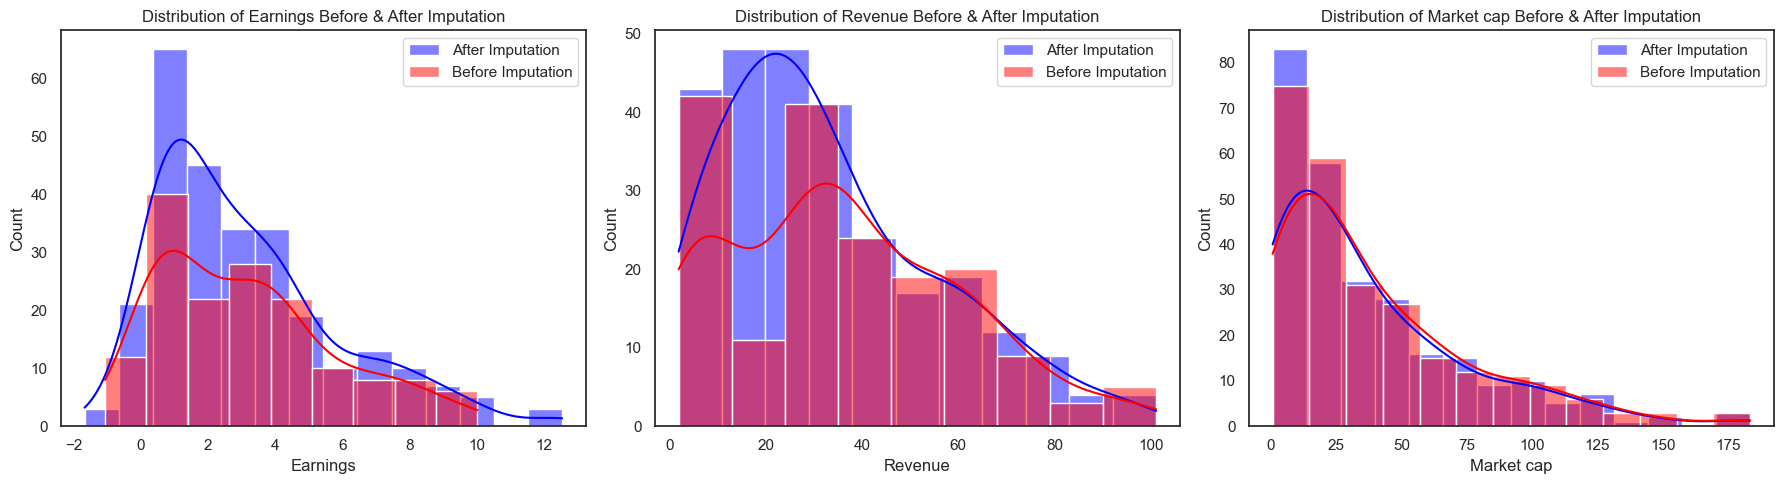

In [71]:
# create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# plot for Earnings
sns.histplot(df1['Earnings'].dropna(), kde=True, color='blue', label='After Imputation', ax=axes[0])
sns.histplot(mc_e_data['Earnings'], kde=True, color='red', label='Before Imputation', alpha=0.5, ax=axes[0])
axes[0].set_title("Distribution of Earnings Before & After Imputation")
axes[0].legend()

# plot for Revenue
sns.histplot(df1['Revenue'].dropna(), kde=True, color='blue', label='After Imputation', ax=axes[1])
sns.histplot(mc_r_data['Revenue'], kde=True, color='red', label='Before Imputation', alpha=0.5, ax=axes[1])
axes[1].set_title("Distribution of Revenue Before & After Imputation")
axes[1].legend()

# plot for Market cap
sns.histplot(df1['Market cap'].dropna(), kde=True, color='blue', label='After Imputation', ax=axes[2])
sns.histplot(mc_imp_data['Market cap'], kde=True, color='red', label='Before Imputation', alpha=0.5, ax=axes[2])
axes[2].set_title("Distribution of Market cap Before & After Imputation")
axes[2].legend()

plt.tight_layout()
plt.show()


After imputation, the shape of our variables has changed, as expected. In the original dataset, up to ±36% of the values in **Earnings** were missing. Despite this transformation, the positive skewness remains similar to its pre-imputation state.  

Next, we'll examine the data for outliers.

# Outliers

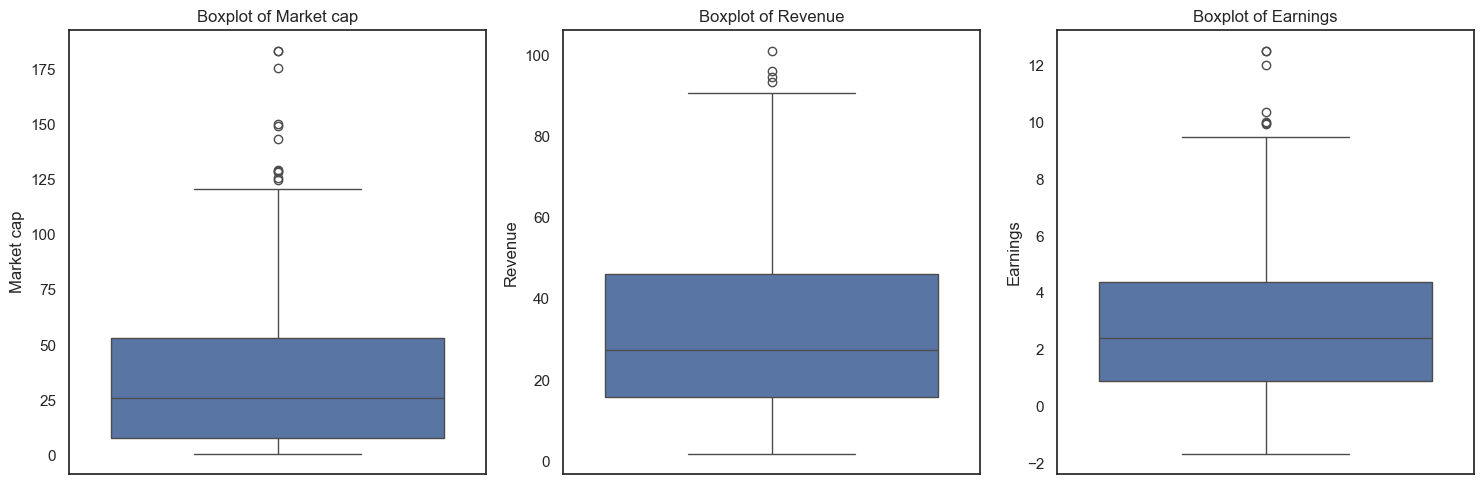

In [72]:
# boxplots of numeric columns

plt.figure(figsize=(15, 5))
for i, column in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df1[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

The imputation of missing values introduced outliers to our numeric variables. This was expected. 

We will now use the IQR method to check how many outliers there are in each column.

In [73]:
# update numn_cols to include post-imputation data
num_cols = pd.DataFrame(df1, columns=['Market cap', 'Revenue', 'Earnings'])

# calculate the IQR for each numerical variable
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

# identify the outliers outside the IQR
outliers = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()
print(f'Number of outliers:\n{num_outliers}')

Number of outliers:
Market cap    11
Revenue        4
Earnings       7
dtype: int64


We will perform a log transformation of the numeric variables to handle outliers. However, **Earnings** has some missing values (see below). These negative values are important since we cannot take the logarithm of a negative value.

In [74]:
# check for negative values in the numeric variables
num_cols.describe()

,Market cap,Revenue,Earnings
count,269.000000,269.000000,269.000000
mean,37.778994,32.955073,3.114350
std,37.489153,22.354956,2.711586
min,0.780000,1.900000,-1.670000
25%,7.890000,16.006000,0.895227
50%,25.960000,27.480000,2.397693
75%,53.130000,46.240000,4.370647
max,183.370000,101.120000,12.530300


In [75]:
# create a new dataframe that will include the log transformations of Market cap, Revenue, and Earnings
df2 = df1.copy()
df2.head()

,Symbol,Year,Name,Country,Category,Market cap,Revenue,Earnings
0,AM.PA,2022,Dassault Aviation,France,Aircraft manufacturers|Defense contractors|Man...,11.91,20.496073,1.464460
1,BA,2001,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,30.94,58.190000,2.692635
2,BA,2002,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,26.37,54.060000,2.397693
3,BA,2003,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,33.72,50.480000,2.872054
4,BA,2004,Boeing,USA,Aircraft manufacturers|Aerospace|Dow jones|Man...,43.08,52.510000,3.476138


In [76]:
# log transform Market Cap and Revenue
df2['Log_Market_Cap'] = np.log1p(df2['Market cap'])
df2['Log_Revenue'] = np.log1p(df2['Revenue'])

# shift Earnings values to ensure they're positive before the transformation
shift_value = abs(df2['Earnings'].min()) + 1
df2['Log_Earnings'] = np.log1p(df2['Earnings'] + shift_value)

# drop original non log-transformed columns
df2.drop(columns=['Market cap', 'Revenue', 'Earnings'], inplace=True)

We repeat the IQR method to ensure our outliers have decreased.

In [77]:
# update numn_cols to include post-imputation data
num_cols = pd.DataFrame(df2, columns=['Log_Market cap', 'Log_Revenue', 'Log_Earnings'])

# calculate the IQR for each numerical variable
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

# identify the outliers outside the IQR
outliers = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()
print(f'Number of outliers:\n{num_outliers}')

Number of outliers:
Log_Market cap    0
Log_Revenue       3
Log_Earnings      0
dtype: int64


### Closing Note:

The data on defense contractors has been thoroughly preprocessed and is now ready to be input into a machine learning model. Before proceeding with model training, it's important to consider the effect of the remaining 3 outliers on model performance. We recommend running experiments both with and without these outliers to evaluate their impact. By comparing the model's performance in both scenarios, you can assess whether the outliers significantly affect the results or if they can be safely retained for further analysis. This step will help ensure that the model produces reliable and robust predictions.